In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import os
os.environ.pop("MPLDEBUG", None)
import tqdm
import torch
from torch.utils.data import DataLoader
from model import FlexControlTripleStreamsVAE
from data import get_flexcontrol_triplestream_dataset
from helpers.control_feature_utils import run_inference_and_extract_features, run_inference, extract_control_features

Could not import fluidsynth. AUDIO rendering will not work.
Holoviews not installed. Please install holoviews to be able to generate heatmaps.


## Load Dataset

### Note: First run, it will take a while to load the dataset, but it will be cached for future runs.

In [3]:
config = yaml.safe_load(open('../helpers/configs/FlexControlTripleStreams_0.5.yaml', 'r'))
config['dataset_root_path'] = os.path.join("../", config['dataset_root_path'])

is_testing = True

dataset = get_flexcontrol_triplestream_dataset(
        config=config,
        subset_tag="validation",
        use_cached=True,
        downsampled_size=2000 if is_testing else None,
        print_logs=False                                #<---  Set to True to print dataset loading logs
    )

In [4]:

dataloader = DataLoader(
    dataset,
    batch_size=1024*4 ,
    shuffle=False,
    num_workers=0
)

## Load Model

In [5]:
from model import load_model
model_path = 'models/step_444276.pth'
model = load_model(
    model_path=model_path,
    model_class=FlexControlTripleStreamsVAE,
    params_dict=config,
    is_evaluating=True
)

#### 1. Keep input constant, then increase control 1 from token 0 to 32 and see if the hamming distance of generation monotonically increases.
##### Here let's keep rest of the controls at gt values, and only vary encoding control 1 token from 0 to 32.

In [6]:
n_samples = len(dataset)

generated_patterns = torch.zeros((33, n_samples, 32, 9))

with torch.no_grad():
    for encoding_control1_val in tqdm.trange(33):
        sample_start = 0
        for batch_data in dataloader:
            input_grooves_batch = batch_data[0]
            encoding_control_tokens = batch_data[2]
            encoding_control_tokens[:, 0] = torch.ones((input_grooves_batch.shape[0]), dtype=torch.long) * encoding_control1_val
            decoding_control_tokens = batch_data[3]
            hvo, latent_z = model.predict(
                flat_hvo_groove=input_grooves_batch,
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            generated_patterns[encoding_control1_val, sample_start:sample_start+input_grooves_batch.shape[0], :, :] = hvo



100%|██████████| 33/33 [01:14<00:00,  2.25s/it]


In [7]:
flat_generated_groove_hits = generated_patterns[:, :, :, :3].sum(dim=-1).clip(0, 1).long()

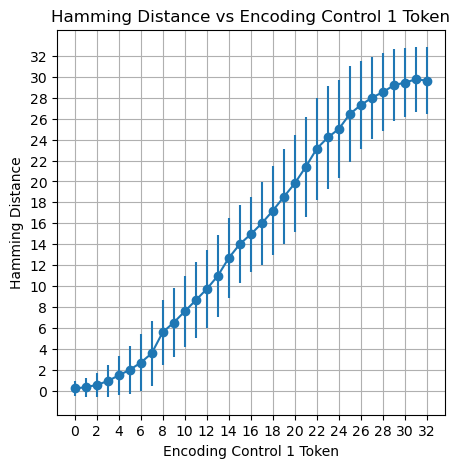

In [8]:
def hamming_distance(a, b):
    """Calculate the Hamming distance between two tensors."""
    return torch.sum(a != b, dim=-1)

hamming_distances = {}

for i in range(33):
    hd_ = hamming_distance(dataset.input_grooves[:, :, 0], flat_generated_groove_hits[i, :, :]).numpy()
    hamming_distances[i] = {'mean': np.mean(hd_), 'std': np.std(hd_)}


# plot mean and std of hamming distances
plt.figure(figsize=(5, 5))
plt.errorbar(
    list(hamming_distances.keys()),
    [hamming_distances[i]['mean'] for i in range(33)],
    yerr=[hamming_distances[i]['std'] for i in range(33)],
    fmt='-o'
)
plt.title('Hamming Distance vs Encoding Control 1 Token')
plt.xlabel('Encoding Control 1 Token')
plt.ylabel('Hamming Distance')
plt.xticks(np.arange(0, 34, 2))
plt.yticks(np.arange(0, 34, 2))
plt.grid()
plt.show()



#### 2. Keep input constant, then increase control 2 from token 0 to 9 and see if the Accent distances change monotonically.
##### Here let's keep rest of the controls at gt values, and only vary encoding control 2 token

In [9]:
n_samples = len(dataset)

generated_patterns = torch.zeros((5, n_samples, 32, 9))

with torch.no_grad():
    for encoding_control2_val in tqdm.trange(5):
        sample_start = 0
        for batch_data in dataloader:
            input_grooves_batch = batch_data[0]
            encoding_control_tokens = batch_data[2]
            encoding_control_tokens[:, 0] = torch.ones((input_grooves_batch.shape[0]), dtype=torch.long) * encoding_control2_val
            decoding_control_tokens = batch_data[3]
            hvo, latent_z = model.predict(
                flat_hvo_groove=input_grooves_batch,
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            generated_patterns[encoding_control2_val, sample_start:sample_start+input_grooves_batch.shape[0], :, :] = hvo



100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


In [10]:
flat_generated_groove_hits = generated_patterns[:, :, :, :3].sum(dim=-1).clip(0, 1).long()
flat_generated_groove_velocities, _ = generated_patterns[:, :, :, 3:6].max(dim=-1)
flat_generated_groove_velocities = flat_generated_groove_velocities * flat_generated_groove_hits

flat_generated_accents = torch.where(flat_generated_groove_velocities > 0.75, 1, 0).long()
input_groove_accents = torch.where(dataset.input_grooves[:, :, 1] > 0.75, 1, 0).long()


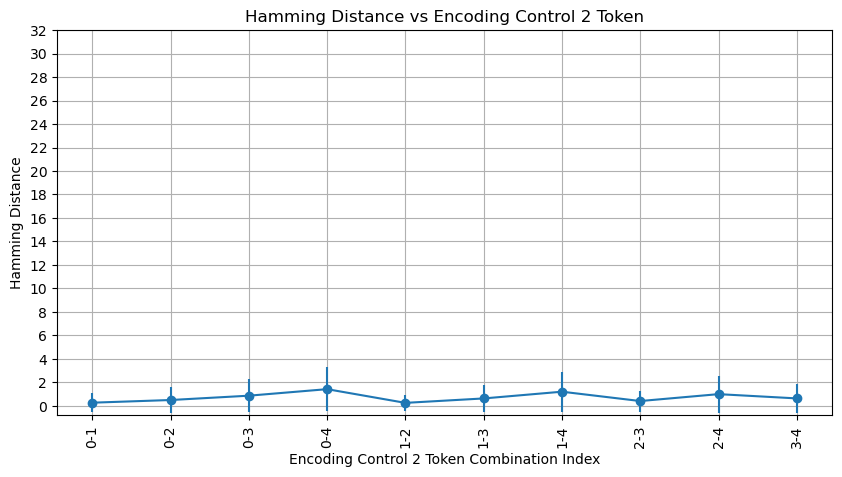

In [11]:
# while control 1 is constant, control 2 is varied. Hence, the flat hits in generations should be the same regardless of control 2 token.
flat_generated_distance = {}

# get all 2 non-repeating combinations of control 2 tokens
from itertools import combinations
combinations_control2 = list(combinations(range(5), 2))
for i, (control2_token1, control2_token2) in enumerate(combinations_control2):
    hd_ = hamming_distance(flat_generated_groove_hits[control2_token1, :, :], flat_generated_groove_hits[control2_token2, :, :]).numpy()
    flat_generated_distance[(control2_token1, control2_token2)] = {'mean': np.mean(hd_), 'std': np.std(hd_)}

# plot mean and std of hamming distances
plt.figure(figsize=(10, 5))
plt.errorbar(
    range(len(flat_generated_distance)),
    [flat_generated_distance[key]['mean'] for key in flat_generated_distance.keys()],
    yerr=[flat_generated_distance[key]['std'] for key in flat_generated_distance.keys()],
    fmt='-o'
)
plt.title('Hamming Distance vs Encoding Control 2 Token')
plt.xlabel('Encoding Control 2 Token Combination Index')
plt.ylabel('Hamming Distance')
plt.xticks(range(len(flat_generated_distance)), [f"{key[0]}-{key[1]}" for key in flat_generated_distance.keys()], rotation=90)
plt.yticks(np.arange(0, 34, 2))
plt.grid()
plt.show()


In [12]:
flat_generated_accents.shape, input_groove_accents.shape

(torch.Size([5, 1986, 32]), torch.Size([1986, 32]))

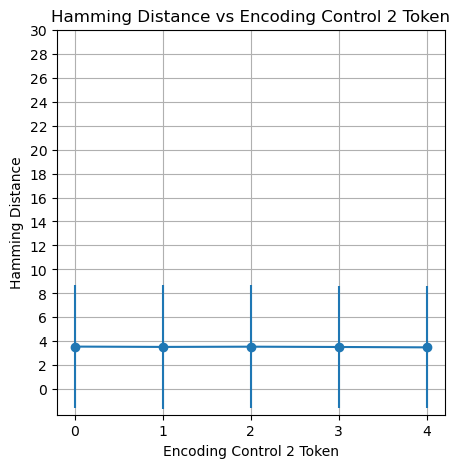

In [13]:

hamming_distances_accents = {}
for i in range(5):
    hd_ = hamming_distance(input_groove_accents, flat_generated_accents[i, :, :]).numpy()
    # # should be normalized by max hamming distance, which is the sum of locations where either input and flat out are 1
    # max_hd = torch.logical_or(input_groove_accents, flat_generated_groove_hits)
    # ensure values that are 0 are set to 1 to avoid division by zero
    # max_hd = max_hd.sum(dim=-1).clip(min=1).numpy()
    # hd_ = hd_ / max_hd
    hamming_distances_accents[i] = {'mean': np.mean(hd_), 'std': np.std(hd_)}

# plot mean and std of hamming distances

plt.figure(figsize=(5, 5))
plt.errorbar(
    list(hamming_distances_accents.keys()),
    [hamming_distances_accents[i]['mean'] for i in range(5)],
    yerr=[hamming_distances_accents[i]['std'] for i in range(5)],
    fmt='-o'
)
plt.title('Hamming Distance vs Encoding Control 2 Token')
plt.xlabel('Encoding Control 2 Token')
plt.ylabel('Hamming Distance')
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 32, 2))
plt.grid()
plt.show()